## Exercício prático 

O objetivo do exercício prático é treinar um modelo capaz de classificar imagens de cães e gatos. As regras do jogo são as seguintes:

    - O dataset base a ser utilizado deve ser o Oxford-IIIT Pet Dataset, disponível publicamente em https://www.robots.ox.ac.uk/~vgg/data/pets. E o modelo deve ser de classificação entre “cão” e “gato”. Não estamos pedindo segmentação semântica nem classificação entre raças;

    - Apesar do dataset original possuir 7.349 imagens, para este desafio você deverá selecionar de antemão apenas 2.000 imagens. As demais não devem entrar nem no treinamento nem na validação. Data augmentation em cima das imagens selecionadas está permitido;

    - Será permitido utilizar qualquer técnica de aprendizado de máquina e qualquer framework de IA, mas o modelo deve ser treinado (ou retreinado) por você;

    - O código pode ser modularizado, mas deve incluir um ou mais notebooks comentando as etapas de extração de dados, análise, preparação, treinamento e avaliação dos resultados usando métricas de sua escolha;

    Lembre-se: não queremos apenas código, então use e abuse do Markdown e gráficos de visualização! Por exemplo:

        Se for retreinar um modelo pré-treinado justifique a escolha deste modelo;

        Apresente a análise exploratória, os critérios e os códigos para a filtragem das 2.000 imagens para treinamento do modelo.


Bônus opcional

    - Pontos extras serão concedidos ao cuidado no empacotamento do código, como setup de ambiente, dependências etc.;

    - Você vai deixar o avaliador mais feliz ainda se a sua solução rodar num contêiner do Docker.

# Parte Inicial - Download de imagens usando wget

In [1]:
#download do tar.gz
#isso pode demorar bastante ao depender da conexão do lado deles (caso esteja muito lenta tente em alguns
#minutos)
# caso ja tenha baixado basta colocar o images.tar.gz na pasta raiz que o docker irá copiar no build
# nesse caso inicie na celula abaixo.
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2022-01-29 10:54:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   775KB/s    in 14m 14s 

2022-01-29 11:08:49 (906 KB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [2]:
#extraindo tudo para pasta images
!tar xf images.tar.gz

In [3]:
#removendo tar.gz
!rm images.tar.gz

In [4]:
#avaliando padrão de nomes!
# comentei porque o output fica enorme dificultando a visualização do notebook
#!dir images 

# Parte Python - preparação de imagens

In [5]:
#importações nativas
import os
import glob
import shutil
import random

#importações libs

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import Image as display_image
from IPython.display import display
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

In [6]:
#setando seed
random.seed(85)

In [7]:
#mapeando todas imagens
images_path = glob.glob(os.path.join('images','*.jpg'))

In [8]:
# pegando apenas o nome da imagem
images_path = [image.split(os.sep)[-1] for image in images_path]

In [9]:
def class_finder(path):
    '''
    Função que realiza a remoção da parte terminal da imagem, ex: _206.jpg
    ARGS:
    path <- caminho
    RETURN:
    string <- nome da imagem (classe)
    '''
    last_part = str(path.split('_')[-1])
    return path.replace('_'+ last_part,'')

In [10]:
#criando uma lista de um conjunto (conjuntos não permitem repetição de elementos!) e aplicando a função acima
classes = list(set([class_finder(path) for path in images_path]))

In [11]:
#confirmando que o número de classes está igual ao descrito no website
len(classes)

37

In [12]:
#aparentemente as classes de gato se iniciam com letra maiuscula!
classes

['wheaten_terrier',
 'pug',
 'Bengal',
 'japanese_chin',
 'Sphynx',
 'Siamese',
 'german_shorthaired',
 'chihuahua',
 'Russian_Blue',
 'english_cocker_spaniel',
 'British_Shorthair',
 'Egyptian_Mau',
 'scottish_terrier',
 'keeshond',
 'english_setter',
 'staffordshire_bull_terrier',
 'american_bulldog',
 'shiba_inu',
 'Maine_Coon',
 'basset_hound',
 'Abyssinian',
 'Birman',
 'saint_bernard',
 'beagle',
 'Ragdoll',
 'samoyed',
 'american_pit_bull_terrier',
 'boxer',
 'newfoundland',
 'havanese',
 'great_pyrenees',
 'yorkshire_terrier',
 'leonberger',
 'pomeranian',
 'miniature_pinscher',
 'Persian',
 'Bombay']

In [13]:
def build_dict(list_classes):
    '''
    Funcão auxiliar para criar um dicionário sendo a key a raça do animal e o valor cachorro/gato
    ARGS:
    list_classes <- lista de nomes
    RETURN:
    dict <- dicionário sendo a key a raça do animal e o valor cachorro/gato 
    '''
    dict_classes = {}
    for classe in list_classes:
        # se iniciar com letra maiúscula é gato, caso contrário cachorro
        if classe[0].isupper():
            dict_classes[classe] = 'cat'
        else:
            dict_classes[classe] = 'dog'
    return dict_classes

In [14]:
#aplicando a função - criando um dicionário
dict_classes = build_dict(classes)

In [15]:
#percorrendo todo dicionário e pegando as keys de gato
cats_list = []
for key,value in dict_classes.items():
    if value == 'cat':
        cats_list.append(key)
    else:
        pass

In [16]:
#criando um dataframe auxiliar para facilitar o processo de visualização
auxiliar_df = pd.DataFrame()

In [17]:
#coluna com os caminhos da imagem
auxiliar_df['path'] = glob.glob(os.path.join('images','*.jpg'))

In [18]:
def find_name(entry,list_elements):
    '''
    Função para binarizar a presença de elementos, caso um dos elementos esteja na entry
    retornará 1, caso contrário 0.
    ARGS:
    entry <- string
    list_elements <- list
    RETURN:
    int <- 0 ou 1
    '''
    for element in list_elements:
        if element in entry:
            return 1
    return 0

In [19]:
def tag_name(entry,list_elements):
    '''
    Função para dar nome a presença de elementos, caso um dos elementos esteja na entry
    retornará o nome caso não retornará None
    ARGS:
    entry <- string
    list_elements <- list
    RETURN:
    int <- 0 ou 1
    '''
    for element in list_elements:
        if element in entry:
            return element
    return None

In [20]:
#aplicando funções
auxiliar_df['Cat'] = auxiliar_df['path'].apply(lambda x: find_name(x,cats_list))
auxiliar_df['Name'] = auxiliar_df['path'].apply(lambda x: tag_name(x,cats_list))

In [21]:
#pegando exemplos de quando são da classe gato
auxiliar_df[auxiliar_df['Cat'] == 1]

,path,Cat,Name
1,images/Bengal_74.jpg,1,Bengal
2,images/Birman_35.jpg,1,Birman
16,images/Birman_3.jpg,1,Birman
19,images/Russian_Blue_236.jpg,1,Russian_Blue
20,images/Bengal_69.jpg,1,Bengal
...,...,...,...
7376,images/British_Shorthair_29.jpg,1,British_Shorthair
7378,images/Siamese_88.jpg,1,Siamese
7379,images/Bombay_115.jpg,1,Bombay
7380,images/Abyssinian_117.jpg,1,Abyssinian


In [22]:
#pegando um exemplo de cada raça! (caminho)
paths_cats = auxiliar_df[auxiliar_df['Cat'] == 1].drop_duplicates(subset=['Cat','Name'])['path'].values

In [23]:
#número de raças de gato
len(paths_cats)

12

# Avaliando imagens dos gatos

In [24]:
def show_many_images(list_images,columns,rows,w=10,h=10,figsize=(8,8)):
    '''
    Função auxiliar para exibir imagens em linhas e colunas!
    ARGS:
    list_images = lista de caminhos de imagem
    columns = inteiro com a quantidade de colunas a serem exibidas
    rows = = inteiro com a quantidade de linhas a serem exibidas
    w = altura (int)
    h = largura (int)
    figsize = tupla ou lista com 2 números inteiros
    RETURN:
    Grid matplotlib (com imagens)
    '''
    fig = plt.figure(figsize=figsize)
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        pil_im = Image.open(list_images[i-1])
        im_array = np.asarray(pil_im)
        plt.imshow(im_array)
    return plt.show()

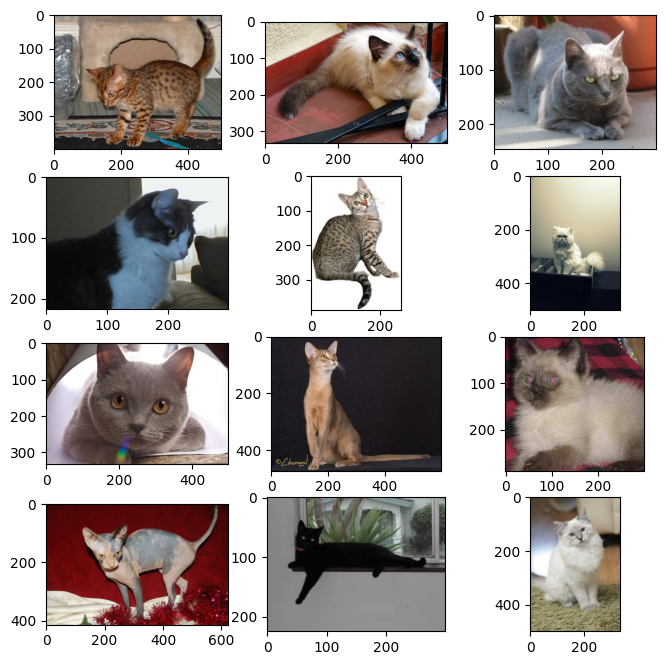

In [25]:
show_many_images(paths_cats,3,4)

# Avaliando cachorros

In [26]:
dogs_list = []
for key,value in dict_classes.items():
    if value == 'dog':
        dogs_list.append(key)

In [27]:
len(dogs_list)

25

In [28]:
#aplicando funções
auxiliar_df['Dog'] = auxiliar_df['path'].apply(lambda x: find_name(x,dogs_list))
auxiliar_df['Name_dogs'] = auxiliar_df['path'].apply(lambda x: tag_name(x,dogs_list))

In [29]:
#pegando exemplos de quando são da classe gato
auxiliar_df[auxiliar_df['Dog'] == 1]

#pegando um exemplo de cada raça! (caminho)
paths_dogs = auxiliar_df[auxiliar_df['Dog'] == 1].drop_duplicates(subset=['Dog','Name_dogs'])['path'].values

In [30]:
paths_dogs

array(['images/chihuahua_37.jpg', 'images/great_pyrenees_134.jpg',
       'images/beagle_84.jpg', 'images/pomeranian_139.jpg',
       'images/american_pit_bull_terrier_201.jpg',
       'images/miniature_pinscher_88.jpg', 'images/boxer_95.jpg',
       'images/shiba_inu_198.jpg', 'images/wheaten_terrier_180.jpg',
       'images/pug_166.jpg', 'images/scottish_terrier_69.jpg',
       'images/staffordshire_bull_terrier_5.jpg',
       'images/basset_hound_181.jpg', 'images/saint_bernard_193.jpg',
       'images/american_bulldog_110.jpg', 'images/japanese_chin_192.jpg',
       'images/keeshond_127.jpg', 'images/leonberger_197.jpg',
       'images/english_cocker_spaniel_24.jpg',
       'images/german_shorthaired_88.jpg', 'images/newfoundland_95.jpg',
       'images/samoyed_111.jpg', 'images/havanese_33.jpg',
       'images/yorkshire_terrier_16.jpg', 'images/english_setter_143.jpg'],
      dtype=object)

In [31]:
#numero de raças de cachorro
len(paths_dogs)

25

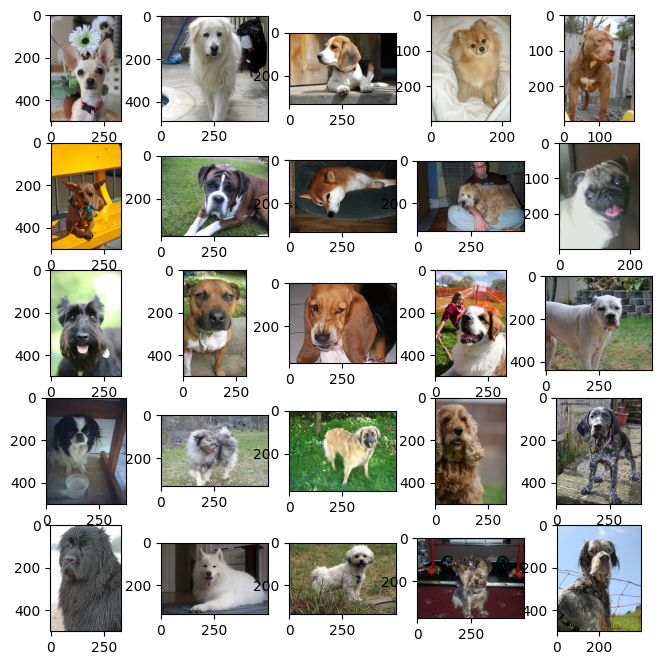

In [32]:
show_many_images(paths_dogs,5,5)

# Ok, temos 12 raças de gato e 25 raças de cães

In [33]:
#criando pastas
try:
    !mkdir -p train{os.sep}dog
    !mkdir -p train{os.sep}cat
except:
    pass

In [34]:
auxiliar_df

,path,Cat,Name,Dog,Name_dogs
0,images/chihuahua_37.jpg,0,None,1,chihuahua
1,images/Bengal_74.jpg,1,Bengal,0,None
2,images/Birman_35.jpg,1,Birman,0,None
3,images/great_pyrenees_134.jpg,0,None,1,great_pyrenees
4,images/beagle_84.jpg,0,None,1,beagle
...,...,...,...,...,...
7385,images/wheaten_terrier_102.jpg,0,None,1,wheaten_terrier
7386,images/english_cocker_spaniel_122.jpg,0,None,1,english_cocker_spaniel
7387,images/Egyptian_Mau_139.jpg,1,Egyptian_Mau,0,None
7388,images/chihuahua_63.jpg,0,None,1,chihuahua


In [35]:
#filtrando df e criando sub-dataframes
dogs_df = auxiliar_df[auxiliar_df['Dog'] == 1].copy()
cats_df = auxiliar_df[auxiliar_df['Cat'] == 1].copy()

In [36]:
dogs_path_img = []
cats_path_img = []

In [37]:
dogs_df

,path,Cat,Name,Dog,Name_dogs
0,images/chihuahua_37.jpg,0,None,1,chihuahua
3,images/great_pyrenees_134.jpg,0,None,1,great_pyrenees
4,images/beagle_84.jpg,0,None,1,beagle
5,images/pomeranian_139.jpg,0,None,1,pomeranian
6,images/american_pit_bull_terrier_201.jpg,0,None,1,american_pit_bull_terrier
...,...,...,...,...,...
7384,images/english_cocker_spaniel_52.jpg,0,None,1,english_cocker_spaniel
7385,images/wheaten_terrier_102.jpg,0,None,1,wheaten_terrier
7386,images/english_cocker_spaniel_122.jpg,0,None,1,english_cocker_spaniel
7388,images/chihuahua_63.jpg,0,None,1,chihuahua


# Escolha de proporções & imagens:
 - Foram escolhidas 1000 imagens de cachorro sendo 40 de cada raça
 - Foram escolhidas 1000 imaagens de gatos sendo 85 de 11 raças e 65 de uma raça
 
 - A 1400 imagens foram usadas para treino, sendo 50% de gatos e 50% de cachorros.
 - A 400 imagens foram usadas para validação, sendo 50% de gatos e 50% de cachorros.
 - A 200 imagens foram usadas para teste, sendo 50% de gatos e 50% de cachorros.
 
 - A escolha das imagens de treino, teste e validação foi utilizando random.sample
 

In [38]:
#criando sample por raças p/ cachorro
for name in dogs_df['Name_dogs'].unique():
    aux = dogs_df[dogs_df['Name_dogs'] == name].sample(40)['path'].values.copy()
    dogs_path_img.extend(aux)

In [39]:
#criando sample por raças p/ gato
for idx,name in enumerate(cats_df['Name'].unique()):
    if idx == 11:
        aux = cats_df[cats_df['Name'] == name].sample(65)['path'].values.copy()
    else:
        aux = cats_df[cats_df['Name'] == name].sample(85)['path'].values.copy()
    cats_path_img.extend(aux)

In [40]:
#verificando quantidade de imagens

In [41]:
len(set(dogs_path_img))

1000

In [42]:
len(set(cats_path_img))

1000

# Movendo arquivos para usar um data generator

In [43]:
dogs_folder = os.path.join('train','dog')
cats_folder = os.path.join('train','cat')

In [44]:
!dir

Dockerfile  build_model\ (1).ipynb  images	      train
README.md   build_model.ipynb	    requirements.txt


In [45]:
#movendo imagens selecionadas de cachorro
for image in dogs_path_img:
    shutil.copy(image,dogs_folder)

In [46]:
#movendo imagens selecionadas de gatos
for image in cats_path_img:
    shutil.copy(image,cats_folder)

In [47]:
len(glob.glob('train/dog/*')) == len(glob.glob('train/cat/*'))

True

In [48]:
#removendo pasta com todas imagens
!rm -r images

In [49]:
#avaliando se a pasta foi removida
!dir

Dockerfile  build_model\ (1).ipynb  requirements.txt
README.md   build_model.ipynb	    train


In [50]:
#criando pastas de validação e teste
try:
    !mkdir -p test{os.sep}dog
    !mkdir -p test{os.sep}cat
    !mkdir -p val{os.sep}dog
    !mkdir -p val{os.sep}cat
except:
    pass
# separando 20 % para validação e 10% para teste    

valid_dog = random.sample(glob.glob('train/dog/*'),200)
valid_cat = random.sample(glob.glob('train/cat/*'),200)

valid_dog_folder = os.path.join('val','dog')
valid_cat_folder = os.path.join('val','cat')

#movendo imagens selecionadas de cachorro
for image in valid_dog:
    shutil.move(image,valid_dog_folder)
    
#movendo imagens selecionadas de gatos
for image in valid_cat:
    shutil.move(image,valid_cat_folder)

test_dog = random.sample(glob.glob('train/dog/*'),100)
test_cat = random.sample(glob.glob('train/cat/*'),100)

test_dog_folder = os.path.join('test','dog')
test_cat_folder = os.path.join('test','cat')

#movendo imagens selecionadas de cachorro
for image in test_dog:
    shutil.move(image,test_dog_folder)
    
#movendo imagens selecionadas de gatos
for image in test_cat:
    shutil.move(image,test_cat_folder)

# Data Generator!

In [53]:
# Aqui definimos geradores para iterar sobre as imagens!
IMG_SIZE = 300
BATCH_SIZE = 8
#adicionando augmentation apenas na base de treino
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function = preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)


valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)


validation_generator = valid_datagen.flow_from_directory(
    'val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)



test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)


Found 1400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Modelo - Utilizando transfer-learning

- Escolhi a EfficientNetB3 porque é o meio termo entre acurácia e tempo de treinamento, bem como a resolução de entrada.
- A EfficientNetB3 também é bem leve (Facilitando o deploy no Heroku)!

In [54]:
#pegando a base do modelo da EfficientNetB3, sem o top
input_shape = tf.keras.Input(shape=(300,300,3))
efnet = tf.keras.applications.EfficientNetB3(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input_shape)
efnet.trainable = False
# Note a forma que o modelo foi construído
# Há 3 formas de construir um modelo com TensorFlow/Keras:
#Sequential API.
#Functional API. -> essa foi a escolhida devido a disponibilidade de capturar as propriedades
# da camada anterior. no módulo Sequential não se tem acesso diretamente a cada uma das camadas
# o que é um requisito para a utilização do GRAD-CAM
#Model subclassing.


# maxpooling + dense + dropout
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)
dense_layer = layers.Dense(256, activation='relu')(gap)
drouput_layer = layers.Dropout(0.2)(dense_layer)
# Finalmente - a camada de saída
output = tf.keras.layers.Dense(2, activation='softmax')(drouput_layer)

#ligando tudo
model = tf.keras.Model(efnet.input, output)

43941136/43941136 [==============================] - 7s 0us/step


In [55]:
#avaliando resumo do modelo
#comentei aqui porque o modelo é bem longo e no github fica muito grande - deixarei no final
#model.summary()

In [56]:
#pegando o nome da última camada de convolução do modelo
for layer in model.layers[-10:]:
    if isinstance(layer, layers.Conv2D):
        print(layer.name)

top_conv


In [57]:
#adicionando callbacks - ajudam a parar o treino quando determinada condição é atendida.

callbacks = [
    EarlyStopping(patience=4,min_delta=0.01),
    ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=4)

]

In [58]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["acc"],
)

In [59]:
#treinando de fato o modelo!
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=10,
    steps_per_epoch=int(np.ceil(train_generator.n / float(BATCH_SIZE))),
    validation_data=validation_generator,
    validation_steps=int(np.ceil(validation_generator.n / float(BATCH_SIZE))),
    validation_batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    workers=4,
    callbacks=[callbacks]
)

Epoch 1/10
175/175 [==============================] - 55s 231ms/step - loss: 1.4136 - acc: 0.9057 - val_loss: 0.0545 - val_acc: 0.9825 - lr: 0.0010
Epoch 2/10
175/175 [==============================] - 41s 234ms/step - loss: 0.1520 - acc: 0.9557 - val_loss: 0.0065 - val_acc: 0.9975 - lr: 0.0010
Epoch 3/10
175/175 [==============================] - 43s 239ms/step - loss: 0.1834 - acc: 0.9529 - val_loss: 0.0017 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/10
175/175 [==============================] - 44s 244ms/step - loss: 0.1059 - acc: 0.9600 - val_loss: 0.0102 - val_acc: 0.9975 - lr: 0.0010
Epoch 5/10
175/175 [==============================] - 44s 243ms/step - loss: 0.0951 - acc: 0.9721 - val_loss: 0.0073 - val_acc: 0.9975 - lr: 0.0010
Epoch 6/10
175/175 [==============================] - 44s 243ms/step - loss: 0.0494 - acc: 0.9850 - val_loss: 0.0059 - val_acc: 0.9975 - lr: 0.0010


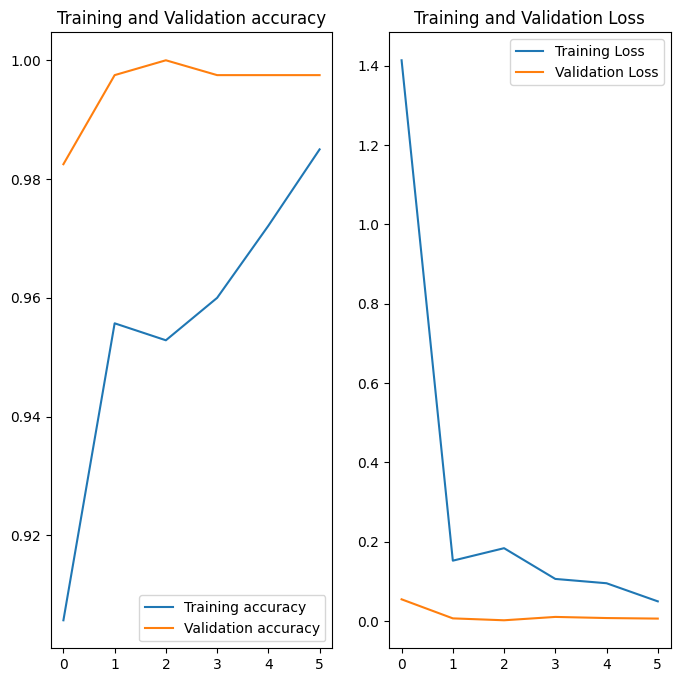

In [60]:
#avaliando performance
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
max_v = max(history.epoch) + 1
epochs_range = range(max_v)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Por que a acurácia da validação está superior ao do treino:
 - Há alguns tópicos que podem explicar isso:
     - As imagens de treino são mais difíceis de serem avaliadas
     - As camadas dropout são ativadas apenas no treinamento (são ignoradas na validação), dessa maneira o dropout prejudica um pouco o erro do treinamento.
     - A taxa de aprendizado estão muito alta, podendo variar demasiado
     - A quantidade de imagens usadas na validação é muito inferior as de treino - podendo ter pouca representatividade.

In [61]:
#avaliando parte avulsa de teste!
test_loss, test_acc = model.evaluate(test_generator, batch_size=BATCH_SIZE,
               verbose=0, steps=(np.ceil(test_generator.n / float(BATCH_SIZE))))

In [62]:
test_acc

0.9950000047683716

In [63]:
def prepare_image(image, target=(300,300)):
    # converte para RFB se não for RGB
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize e processamento
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    return image

# Predição única

In [64]:
sample = random.sample(glob.glob('test/dog/*'),1)[0]

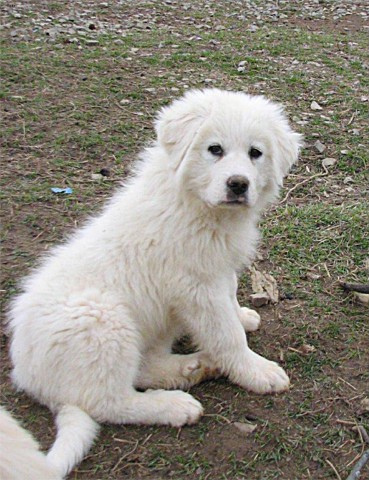

In [65]:
Image.open(sample)

In [66]:
arr = prepare_image(Image.open(sample))

model.predict(arr)

#obtendo labels do gerador!

train_generator.class_indices

dict_classes = {v: k for k,v in train_generator.class_indices.items()}

dict_classes

dict_classes[np.argmax(model.predict(arr))]

1/1 [==============================] - 0s 105ms/step


'dog'

In [67]:
model.save('model.h5')

In [68]:
def get_img_array(img_path, size):
    '''
    Transforma a imagem em um tensor!
    ARGS:
    img_path <- string contendo o caminho da imagem
    size <- tupla com dois inteiros
    RETURN:
    array <- np.array
    '''
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    '''
    img_array <- np.array da imagem
    model <- objeto do modelo
    last_conv_layer_name <- nome da ultima layer de convolução (str)
    pred_index <- int - index da predição
    '''
    # Primeiro, criamos um modelo que mapeia a imagem de entrada para as ativações
    # da última camada de convolução, bem como as previsões de saída.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    # Em seguida, calculamos o gradiente da classe predita (com maior probabildiade) 
    # para nossa imagem de entrada com relação às ativações da última camada de convolução
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradiente do output do neurônio de saida em relação ao mapa de feature da ultima
    #camada de convolução
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vetor para cada entrada é a média da intensidade do gradiente 
    # em relação ao mapa de feature
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    # Multiplicamos cada canal na matriz do mapa de features
    # pelo gradiente (importância do canal) em relação à classe predita com maior probabilidade
    # então soma-se os canais para obter a ativação da classe do mapa de calor
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizando entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [69]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    '''
    Salva e realiza a exibição do gradiente em relação a imagem (sobreposição)
    ARGS:
    img_path <- caminho da imagem (str)
    heatmap <- mapa de calor numpy (np.array)
    cam_path < argumento para salvar a imagem
    alpha = ajuste de transparência
    RETURN:
    imagem sobreposta(apenas display)
    '''
    
    # imagem original
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # rescalando a imagem entre até 255
    heatmap = np.uint8(255 * heatmap)

    # jet para colorizar o "gradiente"
    jet = cm.get_cmap("jet")

    # usando os valores RGB do heatmap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Criando uma imagem com RGB colorido com o heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Sobreposição das imagens
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Salvando a imagem para realizar o display
    superimposed_img.save(cam_path)

    # Display 
    display(display_image(cam_path))
    # Excluí a imagem do caminho salvo
    os.remove(cam_path)

# Avaliação da explicabilidade do modelo.
 - Criar um modelo de Machine Learning é relativamente simples - entretanto o modelo pode conter muitos erros no aprendizado
 - No caso da classificação de imagens podemos usar o [GRAD-CAM](https://arxiv.org/abs/1610.02391) para verificar como as camadas de convolução são ativadas - permitindo que avaliemos se o modelo aprendeu as características corretas.
 - Por exemplo, é contada uma história de um modelo para diferenciar cachorro e lobos - ao avaliar o GRAD-CAM os pesquisadores notaram a presença de marcas d'agua nas imagens de lobo - e que o modelo havia aprendido com foco nas marcas d'agua e não das características do animal

# Abaixo podemos verificar o "mapa de calor das camadas de convolução" sendo junto com a imagem original para o alvo detectado

156438/156438 [==============================] - 1s 5us/step


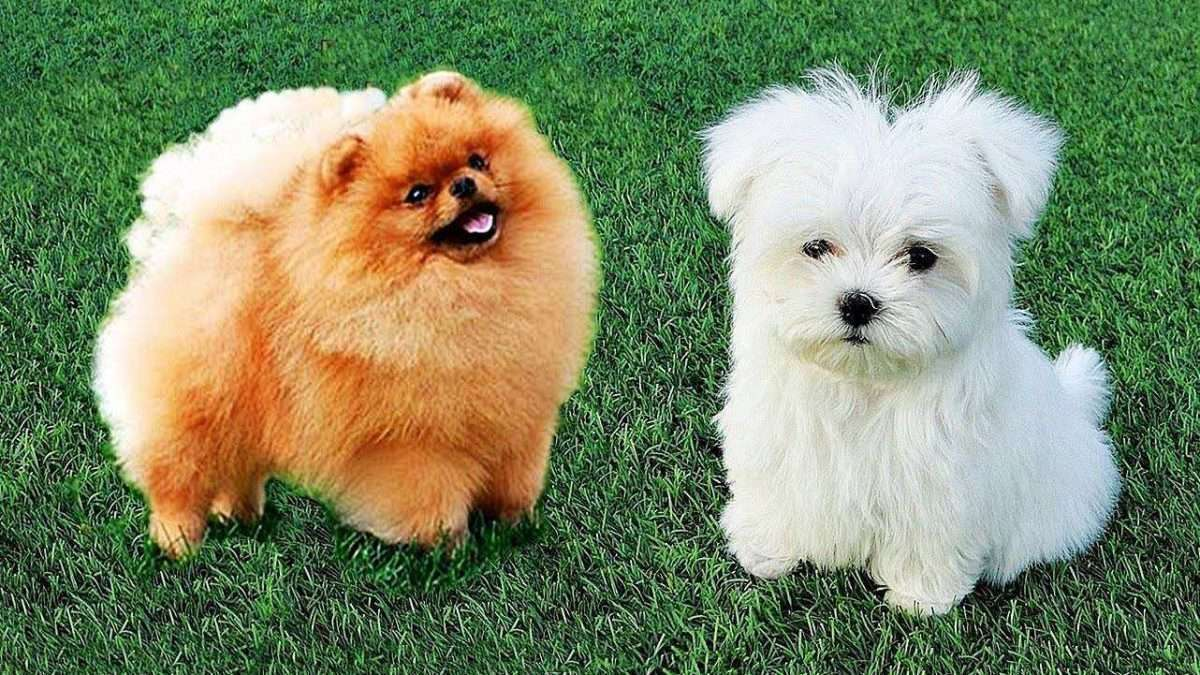

1/1 [==============================] - 0s 104ms/step
Classe predita:  dog
probabilidade classe gato 0.002987268271681387
probabilidade classe cachorro 99.99700784683228


In [70]:
#fazendo download de uma imagem e armazenando.
img_path = keras.utils.get_file(origin="https://sp-ao.shortpixel.ai/client/to_webp,q_glossy,ret_img,w_1200,h_675/https://vedovatipisos.com.br/wp-content/uploads/2015/12/ra%C3%A7as-de-cachorro-1200x675.jpg",
                     fname='dog_sample.jpg'
)

display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = model.predict(img_array)
print('Classe predita: ',dict_classes[np.argmax(pred)])
print('probabilidade classe gato',pred[0][0] * 100)
print('probabilidade classe cachorro',pred[0][1] * 100)

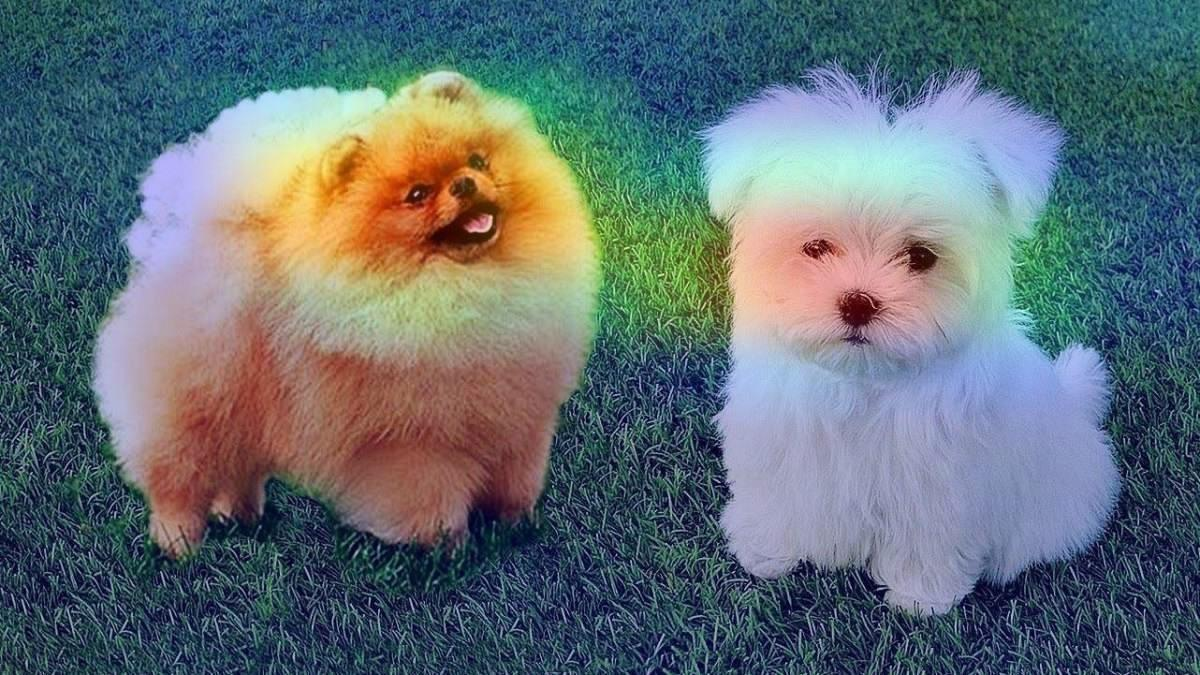

In [71]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

É possível notar que o canto da imagem acaba chamando brevemente a atenção, entretanto o modelo marca bem ambos cachorros.

129136/129136 [==============================] - 0s 3us/step


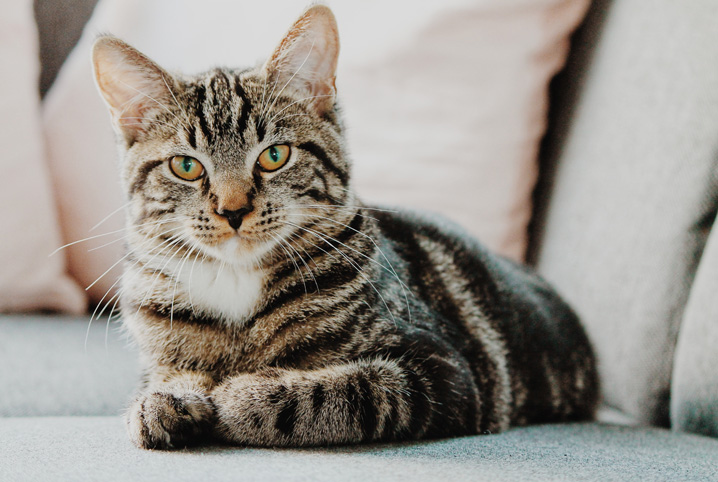

1/1 [==============================] - 0s 103ms/step
Classe predita:  cat
probabilidade classe gato 100.0
probabilidade classe cachorro 1.2193869247667521e-07


In [72]:
img_path = keras.utils.get_file(origin='https://www.dicaspetz.com.br/wp-content/uploads/2019/04/quantos-anos-vive-um-gato.jpg',
                     fname='cat_sample.jpg'
)

display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = model.predict(img_array)
print('Classe predita: ',dict_classes[np.argmax(pred)])
print('probabilidade classe gato',pred[0][0] * 100)
print('probabilidade classe cachorro',pred[0][1] * 100)

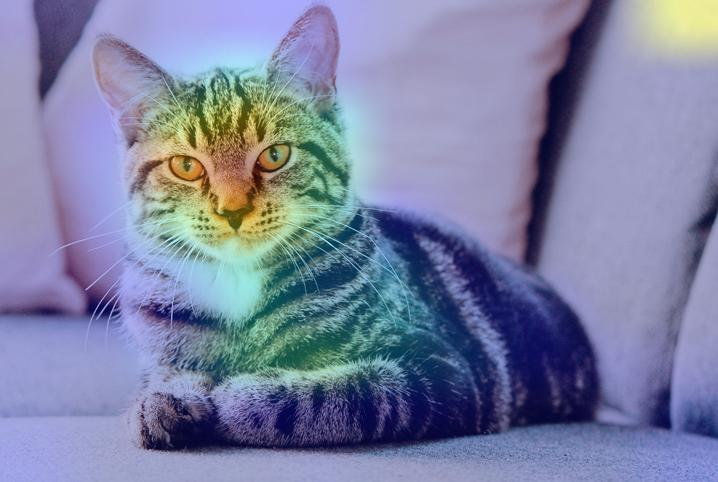

In [73]:
heatmap = make_gradcam_heatmap(img_array, model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

Aqui também é possivel notar um breve gradiente no canto, entretanto a maior parte do mapa de calor está na área correta - isso dá margens para melhoria num ambiente com um número maior de imagens!

# Cachorro e gato na mesma imagem

149998/149998 [==============================] - 1s 7us/step


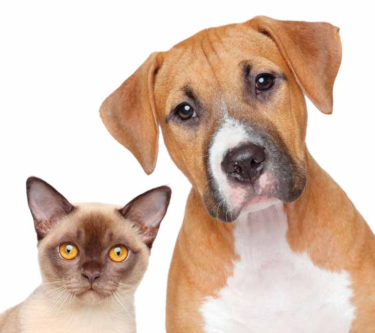

1/1 [==============================] - 0s 104ms/step
Classe predita:  dog
probabilidade classe gato 0.6560556590557098
probabilidade classe cachorro 99.34394955635071


In [74]:
img_path = keras.utils.get_file(origin="https://alavoura.com.br/wp-content/uploads/2018/10/Page-26-Image-664-e1541015066583.png",
                     fname='filename0.jpg'
)

display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = model.predict(img_array)
print('Classe predita: ',dict_classes[np.argmax(pred)])
print('probabilidade classe gato',pred[0][0] * 100)
print('probabilidade classe cachorro',pred[0][1] * 100)

Note que o modelo classifica como cachorro, mas ao varificamos o argmin (classe com mais baixa probabilidade) vemos que o gato foi encontrado (corretamente), mas o cachorro sobrepõe a probabilidade, provavelmente em decorrência da maior variabilidade (25 raças de cachorro vs 12 de gatos)

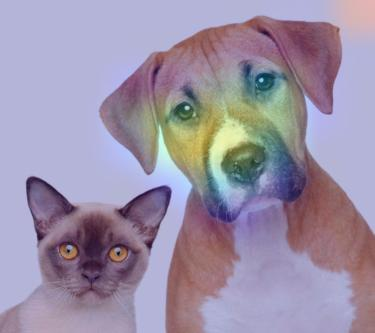

In [75]:
heatmap = make_gradcam_heatmap(img_array, model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

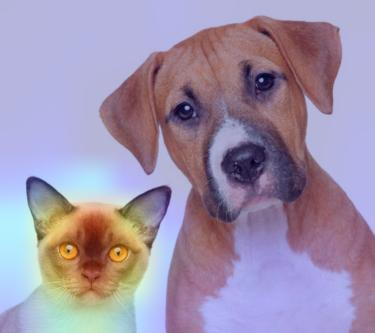

In [76]:
heatmap = make_gradcam_heatmap(img_array, model, 'top_conv', pred_index=np.argmin(pred))
save_and_display_gradcam(img_path, heatmap)

In [77]:
# Note que é possível ter acesso a todas as camadas do modelo que utilizamos de base
# diferentemente de quando criamos um modelo usando a API sequential.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 300, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 300, 300, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              